# Dataset loading

Download datasets.

In [ ]:
!gdown https://drive.google.com/file/d/1aQ_mpyoxlQ2OgJ7vXkPk04sogAIpbyNF/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-1bTtmmSau_o4MHBqT_FizS0-x_TwH4z/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-4T8FSnJK0PZmOuwS295BTg68lA5Q49-/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-7gXamdIWTDISiyOu40bd0xCfg1Q4a-O/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-8A598Uqj2RV705DaFF5HdM2X12bowFx/view?usp=sharing --fuzzy

Mounted at /content/gdrive


Define loading paths.

In [ ]:
tf_records_path = '/content/split_{}.record'

# Dataset decoding

Define a set of decoding functions.

In [ ]:
import tensorflow as tf
import numpy as np

def load_tf_records(filepath):
    filenames = tf.io.gfile.glob(filepath)
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    return dataset

def tf_records_file_features_description():
    image_feature_description = {
        
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([],tf.string),
        'label/P': tf.io.FixedLenFeature([], tf.float32),
        'label/K': tf.io.FixedLenFeature([], tf.float32),
        'label/Mg': tf.io.FixedLenFeature([], tf.float32),
        'label/Ph': tf.io.FixedLenFeature([], tf.float32),
    }
    return image_feature_description

def decode_dataset(example_proto):
    features=tf.io.parse_single_example(example_proto, tf_records_file_features_description())

    image=features['image']
    height=features['image/height']
    width=features['image/width']
    image=tf.io.decode_raw(image,tf.int16)
    image=tf.reshape(image,[height,width,150])

    P=features['label/P']
    K=features['label/K']
    Mg=features['label/Mg']
    Ph=features['label/Ph']

    height=features['image/height']
    width=features['image/width']

    label=[P,K,Mg,Ph]

    return image, label, height, width

# Dataset analysis
This section performs some basic analysis on the dataset which drove the NN design.

It is not required to run this section to train the model.

Load train and test datasets.

In [ ]:
# Load dataset partitions

splits = [load_tf_records(tf_records_path.format(i)).map(decode_dataset, num_parallel_calls=tf.data.AUTOTUNE) for i in range(1,6)]

Concatenate dataset partitions for analysis purposes.

In [ ]:
full_dataset = splits[0].concatenate(splits[1]).concatenate(splits[2]).concatenate(splits[3]).concatenate(splits[4])

Show dataset sizes.

In [ ]:
#[len(list(partition)) for partition in splits] #High RAM usage
num_images = [346, 346, 346, 347, 347]
print('Number of images in each partition: ', num_images)
total_num_images = sum(num_images)
print('Total number of images: ', total_num_images)

Number of images in each partition:  [346, 346, 346, 347, 347]
Total number of images:  1732


Find maximum and minimum intensity values for both datasets.

In [ ]:
# Find maximum reflectance

def find_max(dataset):                      
    max = 0
    for image, label, height, width in dataset:
        max_reflectance = np.amax(image)
        if max_reflectance > max:
            max = max_reflectance
    return(max)

# Find minimum reflectance

def find_min(dataset, min):
    for image, label, height, width in dataset:
        min_reflectance = np.amin(image)
        if min_reflectance < min:
            min = min_reflectance
    return(min)

In [ ]:
max_reflectance_overall = find_max(full_dataset)
min_reflectance_overall = find_min(full_dataset, max_reflectance_overall)
print('Max reflectance overall:', max_reflectance_overall)
print('Min reflectance overall:', min_reflectance_overall)

Max reflectance overall: 5419
Min reflectance overall: -3


Find maximum height and width of images in both datasets.

In [ ]:
shape_data = np.array(list(full_dataset.map(lambda image, label, height, width: tf.shape(image)[0:2]).as_numpy_iterator()))
h_dims, w_dims = np.hsplit(shape_data, 2)

max_height = np.amax(h_dims)
max_width = np.amax(w_dims)
print('Max height train:', max_height)
print('Max width train:', max_width)

Max height train: 268
Max width train: 284


Show image size distribution in a bar chart.

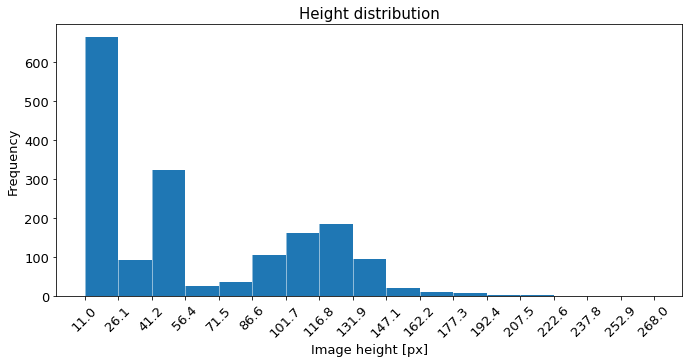

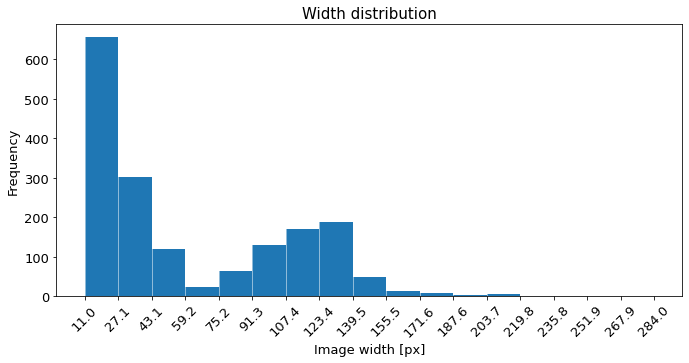

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(12,5))

plt.subplots_adjust(wspace=0.1, hspace=0.4, right=0.85)

n_h, bins_h, patches_h = axs.hist(h_dims, bins='auto')
axs.set_title('Height distribution')
axs.set_xlabel('Image height [px]')
axs.set_ylabel('Frequency')
axs.set_xticks(bins_h)
axs.grid(color='white', lw = 0.5, axis='x')
axs.title.set_size(15)
axs.xaxis.label.set_size(13)
axs.yaxis.label.set_size(13)
axs.tick_params(axis='x', labelrotation=45, labelsize=13)
axs.tick_params(axis='y', labelsize=13)

fig, axs = plt.subplots(1, 1, figsize=(12,5))

plt.subplots_adjust(wspace=0.1, hspace=0.4, right=0.85)

n_w, bins_w, patches_w = axs.hist(w_dims, bins='auto')
axs.set_title('Width distribution')
axs.set_xlabel('Image width [px]')
axs.set_ylabel('Frequency')
axs.set_xticks(bins_w)
axs.grid(color='white', lw = 0.5, axis='x')
axs.title.set_size(15)
axs.xaxis.label.set_size(13)
axs.yaxis.label.set_size(13)
axs.tick_params(axis='x', labelrotation=45, labelsize=13)
axs.tick_params(axis='y', labelsize=13)

plt.show()

Calculate the average, median and standard deviation for the ground truth values.

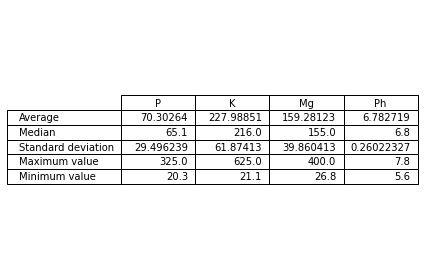

In [ ]:
import pandas as pd

gt_data = np.array(list((full_dataset.map(lambda image, label, height, width: label)).as_numpy_iterator()))

gt_avg = np.mean(gt_data, axis=0)
gt_median = np.median(gt_data, axis=0)
gt_std = np.std(gt_data, axis=0)
gt_max = np.amax(gt_data, axis=0)
gt_min = np.amin(gt_data, axis=0)
gt_stats = np.append([gt_avg], [gt_median, gt_std, gt_max, gt_min], axis=0)

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df=pd.DataFrame(gt_stats, columns=['P', 'K', 'Mg', 'Ph'],)

ax.table(cellText=df.values, colLabels=df.columns, rowLabels=['Average', 'Median', 'Standard deviation', 'Maximum value','Minimum value'], loc='center')

fig.tight_layout()

plt.show()

Find baseline mse in order to later define evaluation metrics.

In [ ]:
mse_baseline = np.mean((gt_data-gt_avg)**2, axis=0)
print(mse_baseline)

[8.7002814e+02 3.8284080e+03 1.5888525e+03 6.7716144e-02]


## PCA analysis

Calculate the covariance matrix for the images in the train set and apply eigendecomposition. The explained variance ratio is also shown so that a proper number of bands can be chosen to later apply PCA.

*Note that the covariance matrix is not calculated individually for each image. Instead, all of the images are taken into account at the same time.*

In [ ]:
# Define functions to prepare the data in order to calculate the covariance matrix considering all of the images.

# Arrange the data in the used format and remove all zero pixels
def prepare_data(image, label, height, width):

    data = tf.cast(tf.reshape(image, [height*width, 150]), dtype='float64')
    data = tf.transpose(data)

    lg_values = data!=0
    mask = tf.math.reduce_any(lg_values, 0)
    data = tf.boolean_mask(data, mask, 1)

    return data

# Sum all pixel values of an image for each channel, required in order to calculate the average
def sum_vector(data):

    mean = tf.math.reduce_sum(data, 1, keepdims=True)

    return mean

# Calculate dot product of the pixel matrix for each image
def dot_product(data):     

    cov = tf.matmul(data, data, transpose_b=True)

    return cov

# Normalize by std 
def normalize(data, std):

    data = data/std

    return data

# Std cacluation
def std(data, mean):

    std = tf.math.reduce_sum((data-mean)**2, 1, keepdims=True)

    return std

In [ ]:
# Find the covariance matrix

data = full_dataset.map(prepare_data)

total_pixels_per_channel = data.map(lambda data: tf.cast(tf.shape(data)[1], dtype='float64')).reduce(np.float64(0), lambda x, y: x+y)

# Find average reflectance to calculate standard deviation
sum_vec = data.map(sum_vector).reduce(tf.zeros([150,1], dtype='float64'), lambda x, y: x+y)     
avg_vec = sum_vec/total_pixels_per_channel

# Find standard deviation for standardization
sigma_vec = data.map(lambda data: std(data, avg_vec)).reduce(np.float64(0), lambda x, y: x+y)   
sigma_vec = tf.math.sqrt(sigma_vec/total_pixels_per_channel)*10

# Apply normalization
data = data.map(lambda data: normalize(data, sigma_vec))    

# Find the average vector for the covariance matrix calculation
sum_vec = data.map(sum_vector).reduce(tf.zeros([150,1], dtype='float64'), lambda x, y: x+y)    
avg_vec = sum_vec/total_pixels_per_channel

# Calculate convaraince matrix
cov_ds = data.map(dot_product).reduce(tf.zeros([150,150], dtype='float64'), lambda x, y: x+y)
cov_mat = cov_ds/total_pixels_per_channel - tf.matmul(avg_vec, avg_vec, transpose_b=True)

np.save('/content/covariance_matrix.npy', cov_mat.numpy())
np.save('/content/std_vector.npy', sigma_vec.numpy())


[0.68364303 0.99023516 0.99586621 0.99881703 0.99911916]


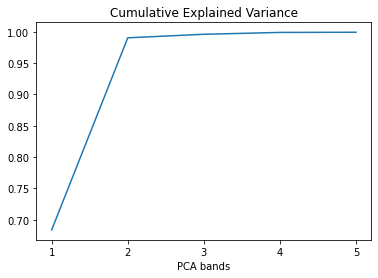

In [ ]:
# Explained variance

[eig_values, eig_vectors] = tf.linalg.eigh(cov_mat)
eig_values = tf.reverse(eig_values, [-1])
sum = tf.reduce_sum(eig_values)
explained_variance = tf.cumsum(eig_values)/sum

fig, ax = plt.subplots()

ax.plot(range(1,6), explained_variance[:5])
ax.set_title('Cumulative Explained Variance')
ax.set_xlabel('PCA bands')
ax.set_xticks([1, 2, 3, 4, 5])

plt.show

print(explained_variance.numpy()[:5])

Print power spectrum to confirm the significance of the explained variance ratio.

In [ ]:
# Functions required to apply PCA

max_gt_values = [325, 625, 400, 14]

def reshape_and_normalize(image, label, height, width, std_vec, max_gt_values):    # Function to reshape and normalize the full dataset
    
    data = tf.reshape(image, [height*width, 150])
    data = tf.cast(data, dtype='float64')
    data = tf.transpose(data)

    data = data/std_vec
    label = label/max_gt_values

    return data, label, height, width

def apply_pca(data, label, height, width, n_pca_bands, cov):    #apply PCA

    [eig_values, eig_vectors] = tf.linalg.eigh(cov)
    eig_vectors = tf.reverse(eig_vectors, axis = [1])
    eig_vectors = eig_vectors[:, :n_pca_bands]

    z = tf.matmul(eig_vectors, data, transpose_a=True)
    z = tf.transpose(z)
    image = tf.reshape(z, [height, width, n_pca_bands])
    image = tf.cast(image, dtype='float32')

    return image, label, height, width

In [ ]:
# Apply PCA
n_pca_bands = 150

PCA_dataset = full_dataset.map(lambda image, label, height, width: reshape_and_normalize(image, label, height, width, sigma_vec, max_gt_values), num_parallel_calls=tf.data.AUTOTUNE)
PCA_dataset = PCA_dataset.map(lambda data, label, height, width: apply_pca(data, label, height, width, n_pca_bands, cov_mat), num_parallel_calls=tf.data.AUTOTUNE).cache()

359


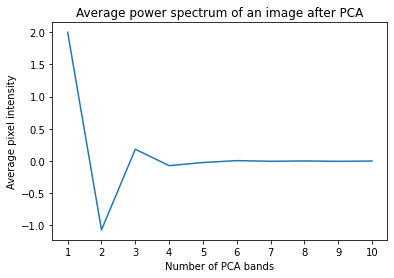

In [ ]:
# Print power spectrum
image_id = np.random.randint(0, 1731)
band_limit = 10

for img, label, height, width in PCA_dataset.skip(image_id).take(1):
    ref = tf.reduce_mean(img[:,:,:band_limit], axis = [0,1])
    plt.plot(range(1,11), ref)
    plt.xticks([1,2,3,4,5,6,7,8,9,10])
    plt.title('Average power spectrum of an image after PCA')
    plt.xlabel('Number of PCA bands')
    plt.ylabel('Average pixel intensity')
    print(image_id)

Find maximum and minimum intensities after PCA.

In [ ]:
max_reflectance_PCA = find_max(PCA_dataset)
min_reflectance_PCA = find_min(PCA_dataset, max_reflectance_PCA)
print('Max reflectance PCA:', max_reflectance_PCA)
print('Min reflectance PCA:', min_reflectance_PCA)

Max reflectance PCA: 6.282844
Min reflectance PCA: -1.4774052


# Dataset preprocessing

Import libraries and set random seeds.

In [ ]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import os
import random as rn
import numpy as np
import tensorflow as tf

rn.seed(2)
np.random.seed(3)
tf.random.set_seed(1)

AUTO = tf.data.AUTOTUNE 

Define preprocessing values.

In [ ]:
max_reflectance_overall = 5419
max_reflectance_PCA = 6.282844

max_height = 268
max_width = 284

total_num_images = 1732
num_images = [346, 346, 346, 347, 347]

max_gt_values = [325, 625, 400, 14]

mse_baseline = [8.7002814e+02, 3.8284080e+03, 1.5888525e+03, 6.7716144e-02]

n_pca_bands = 3

!gdown https://drive.google.com/file/d/1F84KucHWmNoDi_6_DVLN7GfsjtKeFILM/view?usp=sharing --fuzzy
cov = np.load('/content/covariance_matrix.npy')

!gdown https://drive.google.com/file/d/12NScF4TLmZXx2oo-hfEfbkqgi6IYMmiO/view?usp=sharing --fuzzy
std_vec = tf.cast(tf.reshape(np.load('/content/std_vector.npy'), [150]), dtype='float32')

Define normalization and augmentation functions for the train set.

In [ ]:
target_image_size = 32

def reshape_and_normalize(image, label, height, width, std_vec, max_gt_values):    # Function to reshape and normalize the train dataset
    
    data = tf.reshape(image, [height*width, 150])
    data = tf.cast(data, dtype='float64')
    data = tf.transpose(data)

    data = data/std_vec
    label = label/max_gt_values

    return data, label, height, width

def make_horizontal_patch_train(patch, nx):    # Function that repeats a patch horizontally with random flips until the target width is reached, the result is a horizontal band
    
    hor_patch = tf.image.random_flip_left_right(tf.image.random_flip_up_down(patch, seed=72), seed=64)
    i=0

    def cond(hor_patch, patch, i, nx):
        return tf.less(i, nx-1)
    def body(hor_patch, patch, i, nx):
        hor_patch = tf.concat([hor_patch, tf.image.random_flip_left_right(tf.image.random_flip_up_down(patch, seed=49), seed=95)], 1)
        i+=1
        return hor_patch, patch, i, nx

    hor_patch, _, _, _ = tf.while_loop(cond, body, [hor_patch, patch, i, nx])

    return hor_patch

def image_repetition_train(image, height, width):    # Function that repeats small images applying random flips to create a bigger image of the desired size
    
    nx = tf.math.floordiv(target_image_size, tf.cast(width, tf.int32))
    ny = tf.math.floordiv(target_image_size, tf.cast(height, tf.int32))
    patch = image
    image = make_horizontal_patch_train(patch, nx)
    i=0

    def cond(image, patch, i, ny):
        return tf.less(i, ny-1)
    def body(image, patch, i, ny):
        image = tf.concat([image, make_horizontal_patch_train(patch, nx)], 0)
        i+=1
        return image, patch, i, ny
    
    image, _, _, _= tf.while_loop(cond, body, [image, patch, i, ny])

    image = tf.cond(tf.math.maximum(nx, ny)==1, lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False), lambda: tf.image.pad_to_bounding_box(image, 0, 0, target_image_size, target_image_size))

    return image

def pad_with_patches_train(image, label, height, width, n_pca_bands):    #Function to resize images to [target_image_size, target_image_size, n_pca_bands]
    
    max_dim = tf.math.maximum(height, width)
    image = tf.cond(max_dim<target_image_size, lambda: image_repetition_train(image, height, width), lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False))
    image = add_gauss_noise(image, n_pca_bands)

    index = tf.random.uniform(shape=[],maxval=4,dtype=tf.dtypes.int32,seed=32)
    
    image = tf.cond(tf.equal(index,1),lambda: tf.image.flip_left_right(image), lambda: image)

    image = tf.cond(tf.equal(index,2),lambda: tf.image.flip_up_down(image), lambda: image)

    image = tf.cond(tf.equal(index,3),lambda: tf.image.flip_left_right(tf.image.flip_up_down(image)), lambda: image)

    return image, label

def add_gauss_noise(image, n_pca_bands):
  
    mean = 0
    std = tf.reduce_mean(image, [0, 1])*0.3
     
    gauss = tf.random.normal([target_image_size, target_image_size, n_pca_bands], mean, std, seed=910)

    noisy = image + gauss

    return noisy

def apply_pca(data, label, height, width, n_pca_bands, cov):    #apply pca

    [eig_values, eig_vectors] = tf.linalg.eigh(cov)
    eig_vectors = eig_vectors[:, 150-n_pca_bands:]

    z = tf.matmul(eig_vectors, data, transpose_a=True)
    z = tf.transpose(z)
    image = tf.reshape(z, [height, width, n_pca_bands])
    image = tf.cast(image, dtype='float32')

    return image, label, height, width

def post_pca_normalization(image, label, height, width, max_reflectance_PCA):

    image = image/max_reflectance_PCA

    return image, label, height, width


Training setup.

In [ ]:
# Any number in [1,5]
test_partition_id = 5
num_train_images = total_num_images - num_images[test_partition_id-1]

epochs = 400
batch_size = 32
steps_per_epoch = num_train_images//batch_size

Dataset mapping (tf.data.Dataset API).

In [ ]:
# Concatenate partitions to form the train set, the partition chosen as the test partition is excluded
splits = [load_tf_records(tf_records_path.format(i)).map(decode_dataset, num_parallel_calls=tf.data.AUTOTUNE) for i in range(1,6)]
index = list(range(5))
index.pop(test_partition_id-1)

ds = splits[index[0]]
index.pop(0)

for i in index:
    ds = ds.concatenate(splits[i])


# Train
train_data = ds.take(1376)
train_data = train_data.map(lambda image, label, height, width: reshape_and_normalize(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO)    # normalize train dataset
train_data = train_data.map(lambda data, label, height, width: apply_pca(data, label, height, width, n_pca_bands, cov), num_parallel_calls=AUTO).cache()    # apply PCA
train_data = train_data.map(lambda image, label, height, width: post_pca_normalization(image, label, height, width, max_reflectance_PCA), num_parallel_calls=AUTO).cache()   # apply post PCA normalization
train_data = train_data.shuffle(num_train_images, seed=1866)    # shuffle train dataset
train_data = train_data.map(lambda image, label, height, width: pad_with_patches_train(image, label, height, width, n_pca_bands), num_parallel_calls=AUTO)    # pad train dataset
train_data = train_data.batch(batch_size=batch_size, drop_remainder=True)    # batch train dataset
train_data = train_data.prefetch(AUTO)    # prefetch train dataset

# Validation
val_data = ds.skip(1376)    #create validation dataset from the last elements of the train dataset that are discarded during batching
val_data = val_data.map(lambda image, label, height, width: reshape_and_normalize(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO)    # normalize validation dataset 
val_data = val_data.map(lambda data, label, height, width: apply_pca(data, label, height, width, n_pca_bands, cov), num_parallel_calls=AUTO).cache()   # apply pca
val_data = val_data.map(lambda image, label, height, width: post_pca_normalization(image, label, height, width, max_reflectance_PCA), num_parallel_calls=AUTO).cache()   # apply post PCA normalization
val_data = val_data.map(lambda image, label, height, width: pad_with_patches_train(image, label, height, width, n_pca_bands), num_parallel_calls=AUTO)    # pad validation dataset
val_data = val_data.batch(batch_size=10, drop_remainder=False)    # batch validation dataset
val_data = val_data.prefetch(AUTO)    # prefetch validation dataset

Print the bands for some training images.

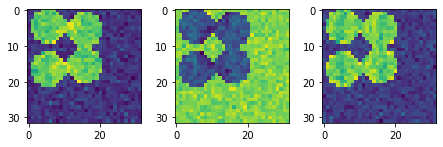

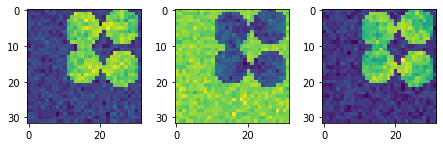

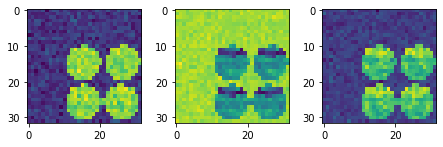

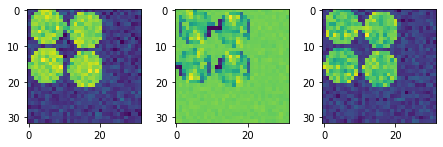

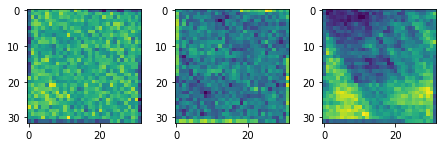

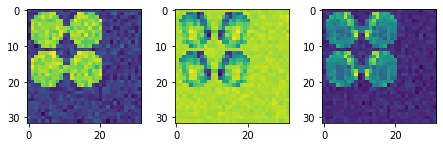

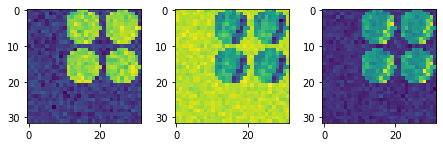

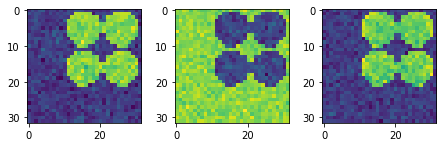

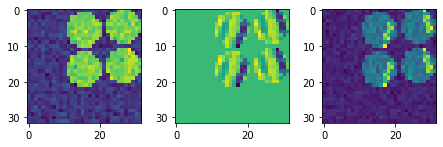

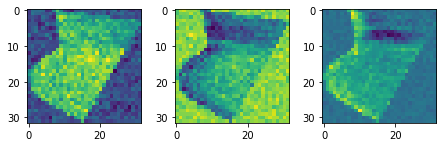

In [ ]:
n_images = 10
k = min(n_pca_bands, 10)

for image, label in train_data.unbatch().take(n_images):
    fig, axs = plt.subplots(1, k, figsize=(25*k/10, 7*k/10))
    for i in range(k):
        axs[i].imshow(image[:,:,n_pca_bands-1-i])

plt.show()
          

Print the validation set.

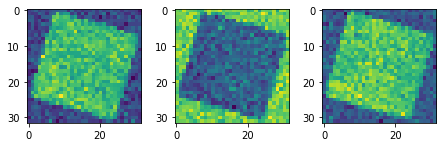

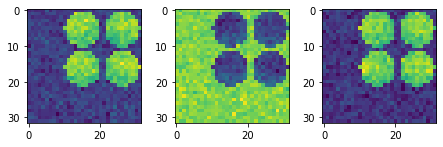

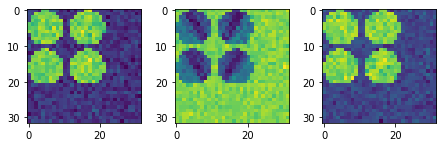

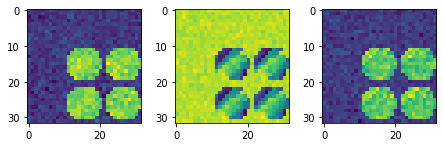

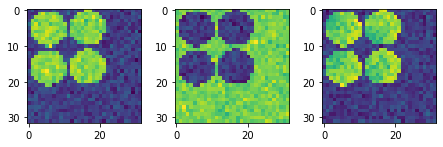

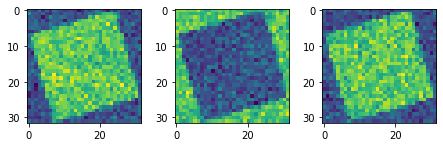

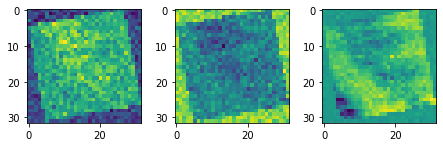

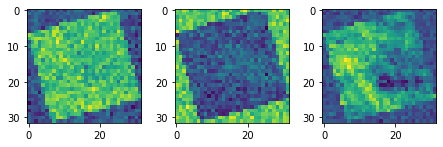

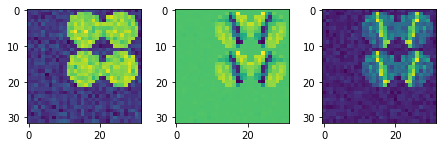

In [ ]:
k = min(n_pca_bands, 10)

for image, label in val_data.unbatch():
    fig, axs = plt.subplots(1, k, figsize=(25*k/10, 7*k/10))
    for i in range(k):
        axs[i].imshow(image[:,:,n_pca_bands-1-i])

plt.show()

# Build and train NN model
EfficientNet-Lite: the following cell is adapted from https://github.com/sebastian-sz/efficientnet-lite-keras, distributed under Apache License 2.0. We defined a new "EfficientNetLiteB0mod" setting width and depth to 0.5.

In [ ]:
import copy
import math

import tensorflow as tf
from tensorflow.keras import layers

if tf.__version__ < "2.8":  # Keras has been moved to separate repository
    from tensorflow.python.keras.applications import imagenet_utils
else:
    from keras.applications import imagenet_utils

from tensorflow.python.keras import backend
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.lib.io import file_io

DEFAULT_BLOCKS_ARGS = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "expand_ratio": 1,
        "id_skip": True,
        "strides": 1,
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_in": 16,
        "filters_out": 24,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_in": 24,
        "filters_out": 40,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_in": 40,
        "filters_out": 80,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_in": 80,
        "filters_out": 112,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_in": 112,
        "filters_out": 192,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
    },
]

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {"scale": 2.0, "mode": "fan_out", "distribution": "truncated_normal"},
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {"scale": 1.0 / 3.0, "mode": "fan_out", "distribution": "uniform"},
}

WEIGHTS_BASE_URL = (
    "https://github.com/sebastian-sz/efficientnet-lite-keras/releases/download/v1.0/"
)
WEIGHTS_HASHES = {
    "efficientnet_lite_b0.h5": "8236b3edc4bd9019865ffd8290cf0b05",
    "efficientnet_lite_b0_notop.h5": "d7a91a3c0e7f0bdffe67f599ebe511cd",
    "efficientnet_lite_b1.h5": "8684671aebaf23b7fb03a0e10fbea162",
    "efficientnet_lite_b1_notop.h5": "9fece5f941068bf189913cd5b42439bf",
    "efficientnet_lite_b2.h5": "e3c7128846d3297734ec7465cb171989",
    "efficientnet_lite_b2_notop.h5": "d0b7d56925cc4b82e30a45570766b32e",
    "efficientnet_lite_b3.h5": "f6a5df9c63310630a5a7f9bcc45c9598",
    "efficientnet_lite_b3_notop.h5": "7ae45c1c6cb1d2ba5193d131984a2225",
    "efficientnet_lite_b4.h5": "25b9276e711f82443523df227aa32cad",
    "efficientnet_lite_b4_notop.h5": "8939585df7b434869381f7786dc60290",
}


def EfficientNetLite(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    blocks_args="default",
    model_name="efficientnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """
    Instantiate the EfficientNet architecture using given scaling coefficients.

    Args:
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_size: integer, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor:  integer, a unit of network width.
        blocks_args: list of dicts, parameters to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: 'imagenet' or path to weights file.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False.
            It should have exactly 3 inputs channels.
        pooling: when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
        classifier_activation: A `str` or callable.
            The activation function to use on the "top" layer. Ignored unless
            `include_top=True`. Set`classifier_activation=None`
            to return the logits of the "top" layer.

    Returns:
        A `keras.Model` instance.

    Raises:
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
        ValueError: if `classifier_activation` is not `softmax` or `None` when
            using a pretrained top layer.
    """
    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS

    if not (weights in {"imagenet", None} or file_io.file_exists_v2(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights` as `"imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    def round_filters(filters, divisor=depth_divisor):
        """Round number of filters based on depth multiplier."""
        filters *= width_coefficient
        new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats):
        """Round number of repeats based on depth multiplier."""
        return int(math.ceil(depth_coefficient * repeats))

    # Build stem
    x = img_input

    x = layers.ZeroPadding2D(
        padding=imagenet_utils.correct_pad(x, 3), name="stem_conv_pad"
    )(x)
    x = layers.Conv2D(
        32,
        3,
        strides=2,
        padding="valid",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="stem_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="stem_bn")(x)
    x = layers.ReLU(max_value=6, name="stem_activation")(x)

    # Build blocks
    blocks_args = copy.deepcopy(blocks_args)
    b = 0
    blocks = float(sum(args["repeats"] for args in blocks_args))

    for (i, args) in enumerate(blocks_args):
        assert args["repeats"] > 0
        # Update block input and output filters based on depth multiplier.
        args["filters_in"] = round_filters(args["filters_in"])
        args["filters_out"] = round_filters(args["filters_out"])

        if i == 0 or i == (len(blocks_args) - 1):
            repeats = args.pop("repeats")
        else:
            repeats = round_repeats(args.pop("repeats"))

        for j in range(repeats):
            # The first block needs to take care of stride and filter size increase.
            if j > 0:
                args["strides"] = 1
                args["filters_in"] = args["filters_out"]
            x = block(
                x,
                drop_connect_rate * b / blocks,
                name="block{}{}_".format(i + 1, chr(j + 97)),
                **args,
            )

            b += 1
    # Build top
    x = layers.Conv2D(
        1280,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="top_bn")(x)
    x = layers.ReLU(max_value=6, name="top_activation")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        model_variant = "efficientnet_lite_b" + model_name[-1]

        if not include_top:
            model_variant += "_notop"

        filename = f"{model_variant}.h5"
        download_url = WEIGHTS_BASE_URL + filename
        weights_path = tf.keras.utils.get_file(
            fname=filename,
            origin=download_url,
            cache_subdir="models",
            file_hash=WEIGHTS_HASHES[filename],
        )
        model.load_weights(weights_path)

    elif weights is not None:
        model.load_weights(weights)

    return model


def block(
    inputs,
    drop_rate=0.0,
    name="",
    filters_in=32,
    filters_out=16,
    kernel_size=3,
    strides=1,
    expand_ratio=1,
    id_skip=True,
):
    """
    Create an inverted residual block.

    Args:
        inputs: input tensor.
        drop_rate: float between 0 and 1, fraction of the input units to drop.
        name: string, block label.
        filters_in: integer, the number of input filters.
        filters_out: integer, the number of output filters.
        kernel_size: integer, the dimension of the convolution window.
        strides: integer, the stride of the convolution.
        expand_ratio: integer, scaling coefficient for the input filters.
        id_skip: boolean.

    Returns:
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1
    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = layers.Conv2D(
            filters,
            1,
            padding="same",
            use_bias=False,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "expand_conv",
        )(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=name + "expand_bn")(x)
        x = layers.ReLU(max_value=6, name=name + "expand_activation")(x)
    else:
        x = inputs

    # Depthwise Convolution
    if strides == 2:
        x = layers.ZeroPadding2D(
            padding=imagenet_utils.correct_pad(x, kernel_size), name=name + "dwconv_pad"
        )(x)
        conv_pad = "valid"
    else:
        conv_pad = "same"
    x = layers.DepthwiseConv2D(
        kernel_size,
        strides=strides,
        padding=conv_pad,
        use_bias=False,
        depthwise_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "dwconv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "bn")(x)
    x = layers.ReLU(max_value=6, name=name + "activation")(x)

    # Skip SE

    # Output phase
    x = layers.Conv2D(
        filters_out,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "project_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "project_bn")(x)
    if id_skip and strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = layers.Dropout(
                drop_rate, noise_shape=(None, 1, 1, 1), name=name + "drop"
            )(x)
        x = layers.add([x, inputs], name=name + "add")
    return x


def EfficientNetLiteB0mod(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    """Create Efficient Net Lite B0 variant."""
    return EfficientNetLite(
        0.5,
        0.5,
        224,
        0.1,
        model_name="efficientnetlite0",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )

Learning rate scheduling.

Learning rate per epoch:


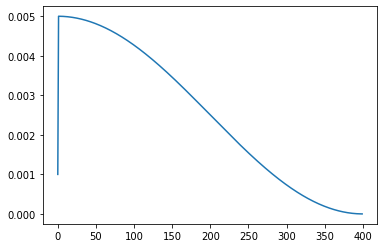

In [ ]:
start_lr = 0.005 #*256/batch_size
alpha = 0.0001
decay_steps = epochs

def lr_scheduler(epoch, start_lr):
    if epoch < 1:
      lr = (start_lr-0.001)/1*epoch+0.001
    else:
      cosine_decay = 0.5 * (1 + tf.cos(np.pi * epoch / (decay_steps)))
      decayed = (1 - alpha) * cosine_decay + alpha
      lr = start_lr * decayed
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_scheduler(epoch, start_lr), verbose=1)

#Plot learning rate

x_range = np.arange(epochs)
y = [lr_scheduler(x, start_lr) for x in x_range]
plt.plot(x_range, y)
print('Learning rate per epoch:')

Create and compile the model.

In [ ]:
network_name = 'EfficientNetLiteB0mod12_GPU_' + str(target_image_size) + 'px_pca_v2_std_norm_cross_validation_' + str(n_pca_bands) + 'bands'

base_model = EfficientNetLiteB0mod(input_shape=(target_image_size, target_image_size, n_pca_bands), weights=None) #multiplo di 32
model = tf.keras.Sequential([base_model,  
                             layers.Flatten(),
                                 layers.Dense(4, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1509))])

def custom_metric(y_true, y_pred):
    y_true = tf.multiply(y_true, max_gt_values)
    y_pred = tf.multiply(y_pred, max_gt_values)
    mse = tf.reduce_mean((y_true-y_pred)**2, axis=0)
    score = tf.reduce_mean(mse/mse_baseline)

    return score

opt = keras.optimizers.Adam(clipnorm=1.)
model.compile(
    optimizer=opt,
    loss='mse',
    metrics=[custom_metric],
  )

model.summary()

print(network_name)

Define saving paths.

In [ ]:
base_path = '/content/'

checkpoint_filepath = base_path + network_name + '/checkpoint_' + str(test_partition_id) 
predictions_filepath = base_path + network_name + '/predictions_' + str(test_partition_id) + '.csv'

print(checkpoint_filepath)
print(predictions_filepath)

Train the model.

In [ ]:
History = model.fit(train_data, epochs=epochs, callbacks=[lr_callback], validation_data=val_data)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/400
43/43 [==============================] - 7s 52ms/step - loss: 0.3995 - custom_metric: 288.0444 - val_loss: 0.1295 - val_custom_metric: 213.0948 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.004999923054128885.
Epoch 2/400
43/43 [==============================] - 2s 42ms/step - loss: 0.4028 - custom_metric: 325.2227 - val_loss: 0.0630 - val_custom_metric: 18.8658 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999691620469093.
Epoch 3/400
43/43 [==============================] - 2s 42ms/step - loss: 0.0427 - custom_metric: 27.4715 - val_loss: 0.0172 - val_custom_metric: 2.3245 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.0049993060529232025.
Epoch 4/400
43/43 [==============================] - 2s 42ms/step - loss: 0.0374 - custom_metric: 17.3860 - val_loss: 0.0072 - val_custom_metric: 2.6238 - lr: 0.0050

Epoch 5: LearningRateSchedul

Export trained model.

In [ ]:
model.save(checkpoint_filepath)

Show some training info.

In [ ]:
min_metric_epoch = tf.math.argmin(History.history['custom_metric'])
min_metric = History.history['custom_metric'][min_metric_epoch]
loss_min_metric = History.history['loss'][min_metric_epoch]
val_metric = History.history['val_custom_metric'][min_metric_epoch]
val_loss = History.history['val_loss'][min_metric_epoch]

print('Best model at epoch', (min_metric_epoch.numpy() + 1))
print('Metric:', min_metric)
print('Loss:', loss_min_metric)
print('Validation metric:', val_metric)
print('Validation loss:', val_loss)

Best model at epoch 397
Metric: 0.6714691519737244
Loss: 0.004528241232037544
Validation metric: 0.5350469350814819
Validation loss: 0.003270407672971487


Show training progress.

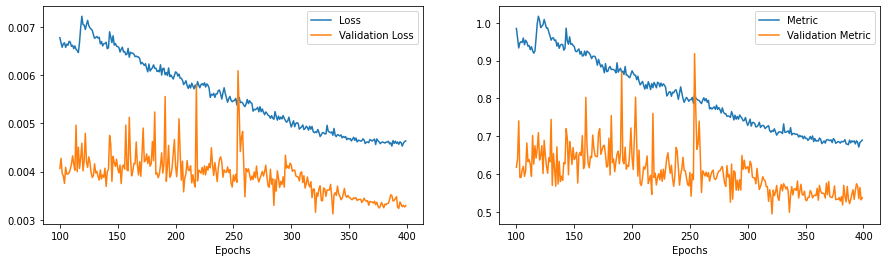

In [ ]:
start_epoch_loss = 100
epochs_interval_loss = range(start_epoch_loss, epochs)
start_epoch_metric = 100
epochs_interval_metric = range(start_epoch_metric, epochs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

ax1.plot(epochs_interval_loss, History.history['loss'][start_epoch_loss:], label='Loss')
ax1.plot(epochs_interval_loss, History.history['val_loss'][start_epoch_loss:], label='Validation Loss')
ax1.set_xlabel("Epochs")
ax1.legend(loc='upper right')

ax2.plot(epochs_interval_metric, History.history['custom_metric'][start_epoch_metric:], label='Metric')
ax2.plot(epochs_interval_metric, History.history['val_custom_metric'][start_epoch_metric:], label='Validation Metric')
ax2.set_xlabel("Epochs")
ax2.legend(loc='upper right')

plt.show()

# Load model and make predictions


Define test set preprocessing functions.

In [ ]:
def reshape_and_normalize(image, label, height, width, std_vec, max_gt_values):    # Function to reshape and normalize the test dataset
    
    data = tf.reshape(image, [height*width, 150])
    data = tf.cast(data, dtype='float64')
    data = tf.transpose(data)

    data = data/std_vec
    label = label/max_gt_values

    return data, label, height, width

def image_repetition_test(image, height, width):    #Function that repeats small images applying random flips to create a bigger image
    nx = tf.math.floordiv(target_image_size, tf.cast(width, tf.int32))
    ny = tf.math.floordiv(target_image_size, tf.cast(height, tf.int32))
    
    image = tf.tile(image, [ny, nx, 1])
    image = tf.cond(tf.math.maximum(nx, ny)==1, lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False), lambda: tf.image.pad_to_bounding_box(image, 0, 0, target_image_size, target_image_size))

    return image

def pad_with_patches_test(image, label, height, width):    #Function to resize images to [target_image_size,target_image_size,n_pca_bands]
    max_dim = tf.math.maximum(height, width)
    image = tf.cond(max_dim<target_image_size, lambda: image_repetition_test(image, height, width), lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False))

    return image, label

def apply_pca(data, label, height, width, n_pca_bands, cov):    #apply pca

    [eig_values, eig_vectors] = tf.linalg.eigh(cov)
    eig_vectors = eig_vectors[:, 150-n_pca_bands:]

    z = tf.matmul(eig_vectors, data, transpose_a=True)
    z = tf.transpose(z)
    image = tf.reshape(z, [height, width, n_pca_bands])
    image = tf.cast(image, dtype='float32')

    return image, label, height, width

def post_pca_normalization(image, label, height, width, max_reflectance_PCA):

    image = image/max_reflectance_PCA

    return image, label, height, width

Preprocessing of test dataset.

In [ ]:
test_data = load_tf_records(tf_records_path.format(test_partition_id)).map(decode_dataset, num_parallel_calls=AUTO)

test_data = test_data.map(lambda image, label, height, width: reshape_and_normalize(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO)    #reshape and normalize test dataset
test_data = test_data.map(lambda data, label, height, width: apply_pca(data, label, height, width, n_pca_bands, cov))   # apply PCA to test set
test_data = test_data.map(lambda image, label, height, width: post_pca_normalization(image, label, height, width, max_reflectance_PCA), num_parallel_calls=AUTO)   # post PCA normalization 
test_data = test_data.map(lambda image, label, height, width: pad_with_patches_test(image, label, height, width), num_parallel_calls=AUTO).cache()    #pad test dataset
test_data = test_data.batch(batch_size=batch_size, drop_remainder=False).prefetch(AUTO)    #batch and prefetch test dataset

Print some entries from test dataset.

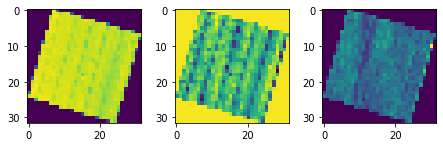

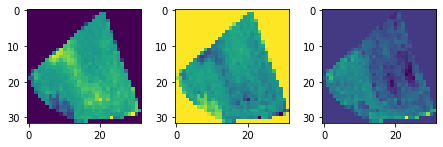

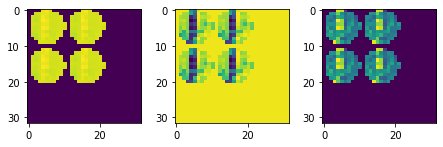

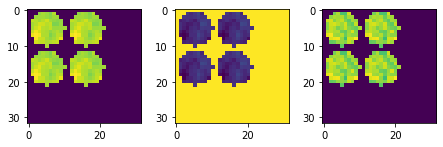

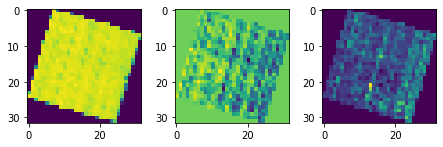

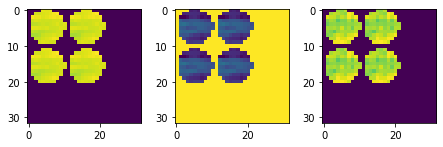

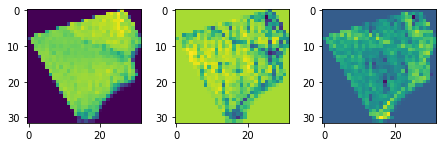

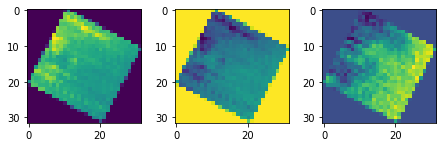

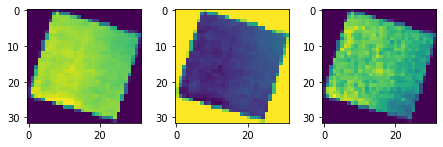

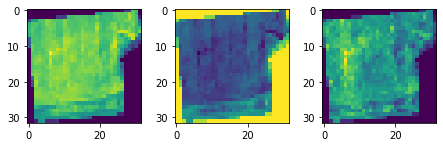

In [ ]:
n_images = 10
k = min(n_pca_bands, 10)

for image, label in test_data.unbatch().take(n_images):
    fig, axs = plt.subplots(1, k, figsize=(25*k/10, 7*k/10))
    for i in range(k):
        axs[i].imshow(image[:,:,n_pca_bands-1-i])

plt.show()

Load the exported model.

In [ ]:
loaded_model = keras.models.load_model(checkpoint_filepath, custom_objects={'custom_metric': custom_metric})

loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetlite0 (Function  (None, 1, 1, 1280)       686560    
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 691,684
Trainable params: 677,444
Non-trainable params: 14,240
_________________________________________________________________


Make predictions and generate csv file.

In [ ]:
predictions = loaded_model.predict(test_data)

predictions_file = pd.DataFrame(data=predictions, columns=["P", "K", "Mg", "pH"])
predictions_file.to_csv(predictions_filepath, index_label="sample_index")

Evaluate model performace.

In [ ]:
gt = np.array(list(test_data.unbatch().map(lambda image, label: label)))

score = custom_metric(gt, predictions)

print(score.numpy())

0.7838855
